<a href="https://colab.research.google.com/github/MukkeshGandhi09/Summer-Intern/blob/master/adapnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.contrib import slim
import numpy as np
import os, sys


In [0]:
class Network(object):
    def __init__(self):
        print ('Network_Construction')

    def _setup(self, data):
        raise NotImplementedError("Implement this method.")

    def _create_loss(self, label):
        raise NotImplementedError("Implement this method.")

    def _create_optimizer(self):
        raise NotImplementedError("Implement this method.")

    def _create_summaries(self):
        raise NotImplementedError("Implement this method.")

    def build_graph(self, data, label=None):
        raise NotImplementedError("Implement this method.")

    def conv2d(self, inputs, kernel_size, stride, out_channels, name=None, padding='SAME'):
        in_channels = inputs.get_shape().as_list()[-1]
        weight_shape = [kernel_size, kernel_size, in_channels, out_channels]
        initializer = tf.contrib.layers.xavier_initializer()

        if self.initializer is 'he':
            n = kernel_size * kernel_size * in_channels
            std = np.sqrt(2.0 / n)
            initializer = tf.truncated_normal_initializer(stddev=std)

        if name is None:
            name = 'weights'

        strides = [1, stride, stride, 1]
        with tf.variable_scope(name):
            kernel = tf.get_variable('', weight_shape,
                                     initializer=initializer,
                                     trainable=self.training,
                                     dtype=self.float_type,
                                     regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay)
                                    )
        return tf.nn.conv2d(inputs, kernel, strides=strides, padding=padding)

    def split_conv2d(self, inputs, kernel_size, rate, out_channels, name=None, padding='SAME', both_atrous=False):
        in_channels = inputs.get_shape().as_list()[-1]
        weight_shape = [kernel_size, kernel_size, in_channels, out_channels]
        initializer = tf.contrib.layers.xavier_initializer()
        if self.initializer is 'he':
            n = kernel_size * kernel_size * in_channels
            std = np.sqrt(2.0 / n)
            initializer = tf.truncated_normal_initializer(stddev=std)
        if name is None:
            name = 'weights'

        strides = [1, 1, 1, 1]
        with tf.variable_scope(name):
            kernel = tf.get_variable('', weight_shape,
                                     initializer=initializer,
                                     trainable=self.training,
                                     dtype=self.float_type,
                                     regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay)
                                    )
        kernelA, kernelB = tf.split(kernel, 2, 3)
        if both_atrous:
            outA = tf.nn.atrous_conv2d(inputs, kernelA, rate, padding=padding)
            outB = tf.nn.atrous_conv2d(inputs, kernelB, rate, padding=padding)
        else:
            outA = tf.nn.conv2d(inputs, kernelA, strides=strides, padding=padding)
            outB = tf.nn.atrous_conv2d(inputs, kernelB, rate, padding=padding)
        return tf.concat((outA, outB), 3)

    def batch_norm(self, inputs):
        in_channels = inputs.get_shape().as_list()[-1]

        with tf.variable_scope('BatchNorm'):
            gamma = tf.get_variable('gamma', (in_channels,), initializer=tf.constant_initializer(1.0),
                                    trainable=self.training, dtype=self.float_type,
                                    regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
            beta = tf.get_variable('beta', (in_channels,), initializer=tf.constant_initializer(0),
                                   trainable=self.training, dtype=self.float_type,
                                   regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay))
            moving_mean = tf.get_variable('moving_mean', (in_channels,),
                                          initializer=tf.constant_initializer(0), trainable=False, dtype=self.float_type)
            moving_var = tf.get_variable('moving_variance', (in_channels,),
                                         initializer=tf.constant_initializer(1), trainable=False, dtype=self.float_type)

        if self.training:
            batch_mean, batch_var = tf.nn.moments(inputs, [0, 1, 2])
            train_mean = tf.assign(moving_mean, moving_mean* self.bn_decay_ + batch_mean * (1 - self.bn_decay_))
            train_var = tf.assign(moving_var, moving_var * self.bn_decay_ + batch_var * (1 - self.bn_decay_))
            with tf.control_dependencies([train_mean, train_var]):
                return  tf.nn.batch_normalization(inputs, batch_mean, batch_var, scale=gamma, offset=beta, variance_epsilon=0.00001)
        else:
            return  tf.nn.batch_normalization(inputs, moving_mean, moving_var, scale=gamma, offset=beta, variance_epsilon=0.00001)

    def pool(self, x, k_size, strides, name=None, padding='SAME'):
        return tf.nn.max_pool(x, [1, k_size, k_size, 1], strides=[1, strides, strides, 1], padding=padding)

    def atrous(self, inputs, kernel_size, rate, out_channels, name=None, padding='SAME'):
        in_channels = inputs.get_shape().as_list()[-1]
        weight_shape = [kernel_size, kernel_size, in_channels, out_channels]
        initializer = tf.contrib.layers.xavier_initializer()

        if self.initializer is 'he':
            n = kernel_size * kernel_size * in_channels
            std = np.sqrt(2.0 / n)
            initializer = tf.truncated_normal_initializer(stddev=std)

        if name is None:
            name = 'weights'

        with tf.variable_scope(name):
            kernel = tf.get_variable('', weight_shape,
                                     initializer=initializer,
                                     trainable=self.training,
                                     dtype=self.float_type,
                                     regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay)
                                    )
        return tf.nn.atrous_conv2d(inputs, kernel, rate, padding=padding)

    def tconv2d(self, inputs, kernel_size, out_channels, stride, name=None, padding='SAME'):
        in_channels = inputs.get_shape().as_list()[-1]
        weight_shape = [kernel_size, kernel_size, out_channels, in_channels]
        n = kernel_size * kernel_size * in_channels
        std = np.sqrt(2.0 / n)

        if name is None:
            name = 'weights'

        initializer = tf.truncated_normal_initializer(stddev=std)
        with tf.variable_scope(name):
            kernel = tf.get_variable('', weight_shape,
                                     initializer=initializer,
                                     trainable=self.training,
                                     dtype=self.float_type,
                                     regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay)
                                    )

        in_shape = tf.shape(inputs)
        h = in_shape[1]*stride
        w = in_shape[2]*stride 
        new_shape = [in_shape[0], h, w, out_channels]
        return tf.nn.conv2d_transpose(inputs, kernel, new_shape, strides=[1, stride, stride, 1], padding=padding)

    def conv_batchN_relu(self, x, kernel_size, stride, out_channels, name, relu=True, dropout=False):
        with tf.variable_scope(name):
            conv_out = self.conv2d(x, kernel_size, stride, out_channels)
            if dropout:
                conv_out = tf.nn.dropout(conv_out, self.keep_prob)
            conv_batch_norm_out = self.batch_norm(conv_out)
            if relu:
                conv_activation = tf.nn.relu(conv_batch_norm_out)
                return conv_activation
            else:
                return conv_batch_norm_out

    def aconv_batchN_relu(self, x, kernel_size, rate, out_channels, name, relu=True):
        with tf.variable_scope(name):
            conv_out = self.atrous(x, kernel_size, rate, out_channels)
            conv_batch_norm_out = self.batch_norm(conv_out)
            if relu:
                conv_activation = tf.nn.relu(conv_batch_norm_out)
                return conv_activation
            else:
                return conv_batch_norm_out

    def unit_v1(self, x, out_channels, stride, block, unit, shortcut=False):
        with tf.variable_scope('block%d/unit_%d/bottleneck_v1'%(block, unit)):
            b_u_1r_cout = self.conv_batchN_relu(x, 1, stride, out_channels/4, name='conv1')
            b_u_3_cout = self.conv_batchN_relu(b_u_1r_cout, 3, 1, out_channels/4, name='conv2')
            b_u_1e_cout = self.conv_batchN_relu(b_u_3_cout, 1, 1, out_channels, name='conv3', relu=False)
            if shortcut:
                b_u_s_cout = self.conv_batchN_relu(x, 1, stride, out_channels, name='shortcut', relu=False)
                b_u_out = tf.nn.relu(tf.add(b_u_1e_cout, b_u_s_cout))
            else:
                b_u_out = tf.nn.relu(tf.add(b_u_1e_cout, x))
            return b_u_out

    def unit_v3(self, x, out_channels, block, unit):
        with tf.variable_scope('block%d/unit_%d/bottleneck_v1'%(block, unit)):
            x1 = self.conv_batchN_relu(x, 1, 1, out_channels/4, name='conv1')
            with tf.variable_scope('conv2'):
                x1 = self.split_conv2d(x1, 3, 2, out_channels/4)
                x1 = self.batch_norm(x1)
                x1 = tf.nn.relu(x1)
        
             
            x1 = self.conv_batchN_relu(x1, 1, 1, out_channels, name='conv3', relu=False)
            x = tf.nn.relu(tf.add(x, x1))
        return x

    def unit_v4(self, x, out_channels, block, unit, shortcut=False, dropout=False):
        with tf.variable_scope('block%d/unit_%d/bottleneck_v1'%(block, unit)):
            b_u_1r_cout = self.conv_batchN_relu(x, 1, 1, out_channels/4, name='conv1')
            with tf.variable_scope('conv2'):
                b3_u3_3_cout = self.split_conv2d(b_u_1r_cout, 3, 2, out_channels/4, both_atrous=True)
                b3_u3_3_bnout = self.batch_norm(b3_u3_3_cout)
                b3_u3_3_ract = tf.nn.relu(b3_u3_3_bnout)
             
            b3_u3_1e_cout = self.conv_batchN_relu(b3_u3_3_ract, 1, 1, out_channels, name='conv3', relu=False)
            if dropout:
        	     b3_u3_1e_cout = tf.nn.dropout(b3_u3_1e_cout, self.keep_prob)

            if shortcut:
                b_u_s_cout = self.conv_batchN_relu(x, 1, 1, out_channels, name='shortcut', relu=False)
                b3_u3_out = tf.nn.relu(tf.add(b_u_s_cout, b3_u3_1e_cout))
            else:
                b3_u3_out = tf.nn.relu(tf.add(x, b3_u3_1e_cout))
        return b3_u3_out

    def fc(self, inputs, out_channels, name):
        in_channels = inputs.get_shape().as_list()[-1]
        weight_shape = [in_channels, out_channels]
        initializer = tf.contrib.layers.xavier_initializer()
        if self.initializer is 'he':
            n = in_channels
            std = np.sqrt(2.0 / n)
            initializer = tf.truncated_normal_initializer(stddev=std)
        name_W = name+'/weights'
        
        with tf.variable_scope(name_W):
            kernel = tf.get_variable('', weight_shape,
                                     initializer=initializer,
                                     trainable=self.training,
                                     dtype=self.float_type, 
                                     regularizer=tf.contrib.layers.l2_regularizer(scale=self.weight_decay)
                                    )
            x = tf.matmul(inputs, kernel)

        with tf.variable_scope(name): 
            b = tf.get_variable('biases', [out_channels], trainable=self.training,
                                initializer=tf.constant_initializer(0.01), dtype=self.float_type)

        return tf.nn.bias_add(x, b, data_format='NHWC')

    def conv_bias(self, inputs, kernel_size, stride, out_channels, name):
        with tf.variable_scope(name):
            x = self.conv2d(inputs, kernel_size, stride, out_channels)
            b = tf.get_variable('biases', [out_channels], trainable=self.training,
                                initializer=tf.constant_initializer(0.01), dtype=self.float_type)
        return tf.nn.bias_add(x, b, data_format='NHWC')      

In [0]:

class AdapNet(Network):
    def __init__(self, num_classes=10, learning_rate=0.001, float_type=tf.float32, weight_decay=0.0005,
                 decay_steps=30000, power=0.9, training=True, ignore_label=True, global_step=0,
                 has_aux_loss=False):
        super(AdapNet, self).__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initializer = 'xavier'
        self.has_aux_loss = has_aux_loss
        self.float_type = float_type
        self.power = power
        self.decay_steps = decay_steps
        self.training = training
        self.bn_decay_ = 0.99
        self.residual_units = [3, 4, 6, 3]
        self.filters = [256, 512, 1024, 2048]
        self.strides = [1, 2, 2, 1]
        self.global_step = global_step

        if self.training:
            self.keep_prob = 0.3
        else:
            self.keep_prob = 1.0
        if ignore_label:
            self.weights = tf.ones(self.num_classes-1)
            self.weights = tf.concat((tf.zeros(1), self.weights), 0)
        else:
            self.weights = tf.ones(self.num_classes)

    def build(self, data):
        self.input_shape = data.get_shape()
        self.conv_3x3_out = self.conv_batchN_relu(data, 3, 1, 3, name='convo')
        self.conv_7x7_out = self.conv_batchN_relu(self.conv_3x3_out, 7, 2, 64, name='conv1')
        self.max_pool_out = self.pool(self.conv_7x7_out, 3, 2)

        ##block1
        self.m_b1_out = self.unit_v1(self.max_pool_out, self.filters[0], 1, 1, 1, shortcut=True)
        for unit_index in range(1, self.residual_units[0]):
            self.m_b1_out = self.unit_v1(self.m_b1_out, self.filters[0], 1, 1, unit_index+1)

        ##block2
        self.m_b2_out = self.unit_v1(self.m_b1_out, self.filters[1], self.strides[1], 2, 1, shortcut=True)
        for unit_index in range(1, self.residual_units[1]-1):
            self.m_b2_out = self.unit_v1(self.m_b2_out, self.filters[1], 1, 2, unit_index+1)
        self.m_b2_out = self.unit_v3(self.m_b2_out, self.filters[1], 2, self.residual_units[1])

        ##block3
        self.m_b3_out = self.unit_v1(self.m_b2_out, self.filters[2], self.strides[2], 3, 1, shortcut=True)
        self.m_b3_out = self.unit_v1(self.m_b3_out, self.filters[2], 1, 3, 2)
        for unit_index in range(2, self.residual_units[2]):
            self.m_b3_out = self.unit_v3(self.m_b3_out, self.filters[2], 3, unit_index+1)

        ##block4
        self.m_b4_out = self.unit_v4(self.m_b3_out, self.filters[3], 4, 1, shortcut=True)
        for unit_index in range(1, self.residual_units[3]):
            dropout = False
            if unit_index == 2:
               dropout = True
            self.m_b4_out = self.unit_v4(self.m_b4_out, self.filters[3], 4, unit_index+1, dropout=dropout)

        ##skip
        self.skip = self.conv_batchN_relu(self.m_b2_out, 1, 1, self.num_classes*2, name='conv2', relu=False)

        ##before upsample     	        
        self.out = self.conv_batchN_relu(self.m_b4_out, 1, 1, self.num_classes, name='conv3', relu=False)

        ### Upsample/Decoder
        with tf.variable_scope('conv4'):
            self.deconv_up1 = self.tconv2d(self.out, 4, self.num_classes*2, 2)
            self.deconv_up1 = self.batch_norm(self.deconv_up1)
            self.up1 = tf.add(self.deconv_up1, self.skip)

        with tf.variable_scope('conv5'):
            self.deconv_up3 = self.tconv2d(self.up1, 16, self.num_classes, 8)
            self.deconv_up3 = self.batch_norm(self.deconv_up3)
            self.softmax = tf.nn.softmax(self.deconv_up3)
        return self.softmax
   

In [0]:
import cv2
import numpy as np
import itertools
import operator
import os, csv
import tensorflow as tf

import time, datetime

def get_label_info(csv_path):
    """
    Retrieve the class names and label values for the selected dataset.
    Must be in CSV format!

    # Arguments
        csv_path: The file path of the class dictionairy
        
    # Returns
        Two lists: one for the class names and the other for the label values
    """
    filename, file_extension = os.path.splitext(csv_path)
    if not file_extension == ".csv":
        return ValueError("File is not a CSV!")

    class_names = []
    label_values = []
    with open(csv_path, 'r') as csvfile:
        file_reader = csv.reader(csvfile, delimiter=',')
        header = next(file_reader)
        for row in file_reader:
            class_names.append(row[0])
            label_values.append([int(row[1]), int(row[2]), int(row[3])])
        # print(class_dict)
    return class_names, label_values


def one_hot_it(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes

    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    # st = time.time()
    # w = label.shape[0]
    # h = label.shape[1]
    # num_classes = len(class_dict)
    # x = np.zeros([w,h,num_classes])
    # unique_labels = sortedlist((class_dict.values()))
    # for i in range(0, w):
    #     for j in range(0, h):
    #         index = unique_labels.index(list(label[i][j][:]))
    #         x[i,j,index]=1
    # print("Time 1 = ", time.time() - st)

    # st = time.time()
    # https://stackoverflow.com/questions/46903885/map-rgb-semantic-maps-to-one-hot-encodings-and-vice-versa-in-tensorflow
    # https://stackoverflow.com/questions/14859458/how-to-check-if-all-values-in-the-columns-of-a-numpy-matrix-are-the-same
    semantic_map = []
    for colour in label_values:
        # colour_map = np.full((label.shape[0], label.shape[1], label.shape[2]), colour, dtype=int)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map
    
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.

    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    # w = image.shape[0]
    # h = image.shape[1]
    # x = np.zeros([w,h,1])

    # for i in range(0, w):
    #     for j in range(0, h):
    #         index, value = max(enumerate(image[i, j, :]), key=operator.itemgetter(1))
    #         x[i, j] = index

    x = np.argmax(image, axis = -1)
    return x


def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.

    # Arguments
        image: single channel array where each value represents the class key.
        label_values
        
    # Returns
        Colour coded image for segmentation visualization
    """

    # w = image.shape[0]
    # h = image.shape[1]
    # x = np.zeros([w,h,3])
    # colour_codes = label_values
    # for i in range(0, w):
    #     for j in range(0, h):
    #         x[i, j, :] = colour_codes[int(image[i, j])]
    
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

# class_dict = get_class_dict("CamVid/class_dict.csv")
# gt = cv2.imread("CamVid/test_labels/0001TP_007170_L.png",-1)
# gt = reverse_one_hot(one_hot_it(gt, class_dict))
# gt = colour_code_segmentation(gt, class_dict)

# file_name = "gt_test.png"
# cv2.imwrite(file_name,np.uint8(gt))

def prepare_data(dataset_dir):
    train_input_names=[]
    train_output_names=[]
    val_input_names=[]
    val_output_names=[]
    test_input_names=[]
    test_output_names=[]
    for file in os.listdir(dataset_dir + "/train"):
        cwd = os.getcwd()
        train_input_names.append(cwd + "/" + dataset_dir + "/train/" + file)
    for file in os.listdir(dataset_dir + "/train_labels"):
        cwd = os.getcwd()
        train_output_names.append(cwd + "/" + dataset_dir + "/train_labels/" + file)
    for file in os.listdir(dataset_dir + "/val"):
        cwd = os.getcwd()
        val_input_names.append(cwd + "/" + dataset_dir + "/val/" + file)
    for file in os.listdir(dataset_dir + "/val_labels"):
        cwd = os.getcwd()
        val_output_names.append(cwd + "/" + dataset_dir + "/val_labels/" + file)
    for file in os.listdir(dataset_dir + "/test"):
        cwd = os.getcwd()
        test_input_names.append(cwd + "/" + dataset_dir + "/test/" + file)
    for file in os.listdir(dataset_dir + "/test_labels"):
        cwd = os.getcwd()
        test_output_names.append(cwd + "/" + dataset_dir + "/test_labels/" + file)
    train_input_names.sort(),train_output_names.sort(), val_input_names.sort(), val_output_names.sort(), test_input_names.sort(), test_output_names.sort()
    return train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names

def load_image(path): 
    image1=cv2.imread(path,-1)
    #cv2.imshow(image1)
    image = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    return image1

# Takes an absolute file path and returns the name of the file without th extension
def filepath_to_name(full_name):
    file_name = os.path.basename(full_name)
    file_name = os.path.splitext(file_name)[0]
    return file_name

# Print with time. To console or file
def LOG(X, f=None):
    time_stamp = datetime.datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
    if not f:
        print(time_stamp + " " + X)
    else:
        f.write(time_stamp + " " + X)


# Count total number of parameters in the model
def count_params():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    print("This model has %d trainable parameters"% (total_parameters))

# Input Pipeline

In [5]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
os.chdir('/')
csvpath="content/drive/My Drive/CamVid/class_dict.csv"
datasetpath="content/drive/My Drive/CamVid"
class_names_list, label_values = get_label_info(csv_path=csvpath)
class_names_string = ""
for class_name in class_names_list:
    if not class_name == class_names_list[-1]:
        class_names_string = class_names_string + class_name + ", "
    else:
        class_names_string = class_names_string + class_name

num_classes = len(label_values)
train_input_names,train_output_names, val_input_names, val_output_names, test_input_names, test_output_names = prepare_data(dataset_dir=datasetpath)
print(train_input_names)

['//content/drive/My Drive/CamVid/train/0001TP_006690.png', '//content/drive/My Drive/CamVid/train/0001TP_006720.png', '//content/drive/My Drive/CamVid/train/0001TP_006750.png', '//content/drive/My Drive/CamVid/train/0001TP_006780.png', '//content/drive/My Drive/CamVid/train/0001TP_006810.png', '//content/drive/My Drive/CamVid/train/0001TP_006840.png', '//content/drive/My Drive/CamVid/train/0001TP_006990.png', '//content/drive/My Drive/CamVid/train/0001TP_007020.png', '//content/drive/My Drive/CamVid/train/0001TP_007050.png', '//content/drive/My Drive/CamVid/train/0001TP_007080.png', '//content/drive/My Drive/CamVid/train/0001TP_007110.png', '//content/drive/My Drive/CamVid/train/0001TP_007140.png', '//content/drive/My Drive/CamVid/train/0001TP_007290.png', '//content/drive/My Drive/CamVid/train/0001TP_007320.png', '//content/drive/My Drive/CamVid/train/0001TP_007350.png', '//content/drive/My Drive/CamVid/train/0001TP_007380.png', '//content/drive/My Drive/CamVid/train/0001TP_007410.pn

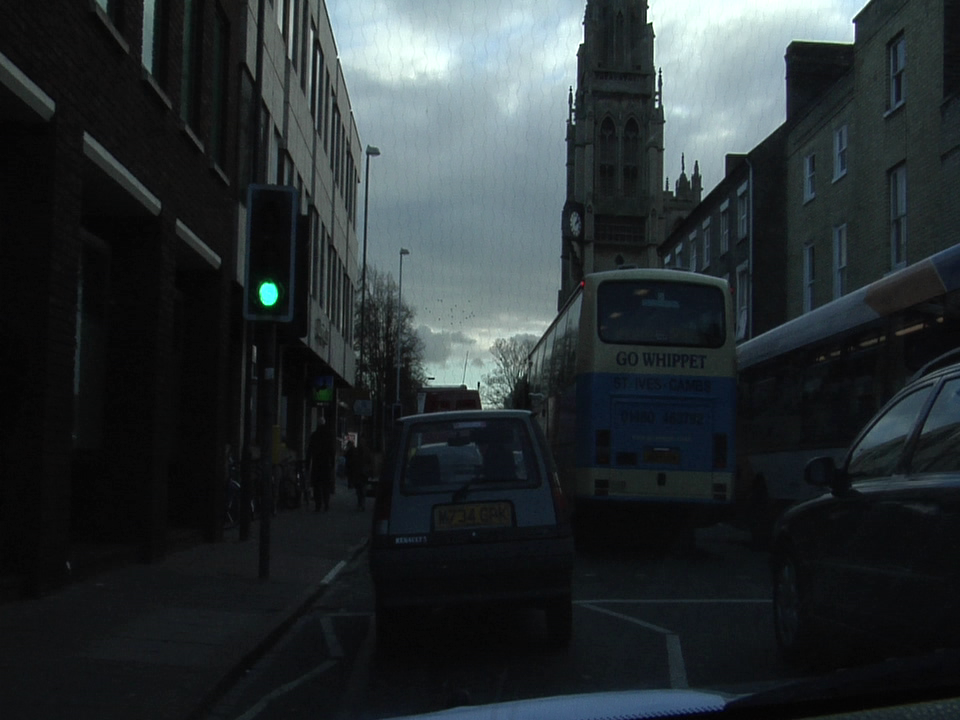

In [7]:
from IPython.display import Image
Image('//content/drive/My Drive/CamVid/train/0001TP_006690.png')

# Training Loop

In [8]:
num_classes=10
epochsize=10
batch_size=5
batch_counter=0
Input  = tf.placeholder(tf.float32,shape=[None,None,None,3])
Output = tf.placeholder(tf.float32,shape=[None,None,None,num_classes])
init=AdapNet()
model=init.build(Input)
cross_entropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=model,labels=Output)
loss = tf.reduce_mean(cross_entropy)
opt=tf.train.AdamOptimizer().minimize(loss)

Network_Construction


W0625 19:00:46.165448 140710412019584 deprecation.py:506] From <ipython-input-2-481f332b0a06>:201: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0625 19:00:46.167118 140710412019584 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [14]:

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(0,epochsize):
      current_losses = []
      cnt=0
      # Equivalent to shuffling
      id_list = np.random.permutation(len(train_input_names))
      num_iters = int(np.floor(len(id_list)/batch_size))
      st = time.time()
      epoch_st=time.time()
      for i in range(num_iters):
          # st=time.time()
          input_image_batch = []
          output_image_batch = []
          for j in range(batch_size):
              index = i*batch_size + j
              id = id_list[index]
              input_image = load_image(train_input_names[id])
              output_image =load_image(train_output_names[id])
              input_image = np.float32(input_image) / 255.0
              output_image = np.float32(one_hot_it(label=output_image, label_values=label_values))
              input_image_batch.append(np.expand_dims(input_image, axis=0))
              output_image_batch.append(np.expand_dims(output_image, axis=0))
          if batch_size == 1:
              input_image_batch = input_image_batch[0]
              output_image_batch = output_image_batch[0]
          else:
              input_image_batch = np.squeeze(np.stack(input_image_batch, axis=1))
              output_image_batch = np.squeeze(np.stack(output_image_batch, axis=-1))
          _,current=sess.run([opt,loss],feed_dict={Input:input_image_batch,Output:output_image_batch})
          current_losses.append(current)
          cnt = cnt + args.batch_size
          if cnt % 20 == 0:
              string_print = "Epoch = %d Count = %d Current_Loss = %.4f Time = %.2f"%(epoch,cnt,current,time.time()-st)
              utils.LOG(string_print)
              st = time.time()
      mean_loss = np.mean(current_losses)
      avg_loss_per_epoch.append(mean_loss)
      print("\nmean_loss=%.4f",mean_losses)

   


ResourceExhaustedError: ignored